## Install and load required packages

In [1]:
installOrLoadPackage <- function(listOfPackages) {
	repository <- 'https://cloud.r-project.org/'
	for (package in listOfPackages) {
		if (package %in% row.names(installed.packages()) == TRUE) {
			update.packages(package, dependecies = TRUE, repos=repository)
		} else {
			install.packages(package, repos=repository)
		}
		require(package, character.only = TRUE)
	}
}
installOrLoadPackage(c('httr', 'rjson'))
installOrLoadPackage(c('MASS', 'RColorBrewer', 'flexclust', 'randomForest'))
installOrLoadPackage(c('maps', 'ggmap'))
installOrLoadPackage('Cairo')
options(jupyter.plot_mimetypes = 'image/png')

Loading required package: httr
Warning message:
"package 'httr' was built under R version 3.3.3"Loading required package: rjson
Loading required package: MASS
Loading required package: RColorBrewer
Loading required package: flexclust
Warning message:
"package 'flexclust' was built under R version 3.3.3"Loading required package: grid
Loading required package: modeltools
Loading required package: stats4
Loading required package: randomForest
Warning message:
"package 'randomForest' was built under R version 3.3.3"randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.
Loading required package: maps
Warning message:
"package 'maps' was built under R version 3.3.3"Loading required package: ggmap
Warning message:
"package 'ggmap' was built under R version 3.3.3"Loading required package: ggplot2

Attaching package: 'ggplot2'

The following object is masked from 'package:randomForest':

    margin

Installing package into 'C:/Users/joebrillantes/Documents/R/win-library/3.3'
(

package 'Cairo' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\joebrillantes\AppData\Local\Temp\RtmpysoxSM\downloaded_packages


Loading required package: Cairo


## Get data from https://roadsafety.gov.ph/
## JSON data returned from the API is placed in a list

In [ ]:
set_config(config(ssl_verifypeer = 0L))

authorization <- 'Token <replace with a 40-character long token that you can get when you register at roadsafety.gov.ph>'

getSchemaURL <- GET(
   url = 'https://roadsafety.gov.ph/api/recordtypes/?active=True&label=Incident', 
   add_headers(Authorization=authorization))
uuid <- fromJSON(content(getSchemaURL,type="text"))$results[[1]]$uuid
current_schema <- fromJSON(content(getSchemaURL,type="text"))$results[[1]]$current_schema
url_schema <- paste('https://roadsafety.gov.ph/api/recordschemas/', current_schema, sep='')

getSchema <- GET(url = url_schema, add_headers(Authorization=authorization))

bodyList <- list(
	archived='False',
	record_type=uuid)
url <- 'https://roadsafety.gov.ph/api/records/'
rawData <- as.character()

while (!is.null(url)) {
	getData <- GET(url = url,
		add_headers(Authorization=authorization),
		body = bodyList,
		encode = 'form')
	url <- fromJSON(content(getData,type="text"))['next'][[1]]
	rawData <- c(rawData, content(getData,type="text"))
}
head(rawData)

No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding supplied: defaulting to UTF-8.
No encoding

## Process JSON data to a data frame

In [3]:
procData <- as.data.frame(matrix(NA, nrow=0, ncol=25))
names(procData) <- c('uuid', 'description', 'reporting_agency', 'main_cause',
	'localid', 'collision_type', 'severity', 'created', 'modified',
	'occured_from', 'occured_to', 'geom_type', 'lon', 'lat',
	'location_text', 'city', 'city_district', 'county', 'neighborhood',
	'road', 'state', 'weather', 'light', 'archived', 'schema')

for (i in 1:length(rawData)) {
	temp0 <- fromJSON(rawData[i])
	temp1 <- as.data.frame(matrix(NA, nrow=length(temp0$results), ncol=25))
	names(temp1) <- names(procData)
	for (j in 1:length(temp0$results)) {
		temp1$uuid[j] <- ifelse(!is.null(temp0$results[[j]][['uuid']]),temp0$results[[j]][['uuid']], NA) 
		temp1$description[j] <- ifelse(!is.null(temp0$results[[j]]$data$incidentDetails[['Description']]), 
                                       temp0$results[[j]]$data$incidentDetails[['Description']], NA)
		temp1$reporting_agency[j] <- ifelse(!is.null(temp0$results[[j]]$data$incidentDetails[['Reporting Agency']]), 
                                            temp0$results[[j]]$data$incidentDetails[['Reporting Agency']], NA)
		temp1$main_cause[j] <- ifelse(!is.null(temp0$results[[j]]$data$incidentDetails[['Main cause']]), 
                                      temp0$results[[j]]$data$incidentDetails[['Main cause']], NA)
		temp1$localid[j] <- ifelse(!is.null(temp0$results[[j]]$data$incidentDetails[['_localId']]), 
                                   temp0$results[[j]]$data$incidentDetails[['_localId']], NA)
		temp1$collision_type[j] <- ifelse(!is.null(temp0$results[[j]]$data$incidentDetails[['Collision type']]), 
                                          temp0$results[[j]]$data$incidentDetails[['Collision type']], NA)
		temp1$severity[j] <- ifelse(!is.null(temp0$results[[j]]$data$incidentDetails[['Severity']]) & 
                                    length(temp0$results[[j]]$data$incidentDetails[['Severity']]) > 0, 
                                    temp0$results[[j]]$data$incidentDetails[['Severity']][[1]], NA)
		temp1$created[j] <- ifelse(!is.null(temp0$results[[j]][['created']]), 
                                   temp0$results[[j]][['created']], NA)
		temp1$modified[j] <- ifelse(!is.null(temp0$results[[j]][['modified']]), 
                                    temp0$results[[j]][['modified']], NA)
		temp1$occured_from[j] <- ifelse(!is.null(temp0$results[[j]][['occurred_from']]), 
                                        temp0$results[[j]][['occurred_from']], NA)
		temp1$occured_to[j] <- ifelse(!is.null(temp0$results[[j]][['occurred_to']]), 
                                      temp0$results[[j]][['occurred_to']], NA)
		temp1$geom_type[j] <- ifelse(!is.null(temp0$results[[j]]$geom[['type']]), 
                                     temp0$results[[j]]$geom[['type']], NA)
		temp1$lon[j] <- ifelse(!is.null(temp0$results[[j]]$geom$coordinates[[1]]), 
                               temp0$results[[j]]$geom$coordinates[[1]], NA)
		temp1$lat[j] <- ifelse(!is.null(temp0$results[[j]]$geom$coordinates[[2]]), 
                               temp0$results[[j]]$geom$coordinates[[2]], NA)
		temp1$location_text[j] <- ifelse(!is.null(temp0$results[[j]][['location_text']]), 
                                         temp0$results[[j]][['location_text']], NA)
		temp1$city[j] <- ifelse(!is.null(temp0$results[[j]][['city']]), 
                                temp0$results[[j]][['city']], NA)
		temp1$city_district[j] <- ifelse(!is.null(temp0$results[[j]][['city_district']]), 
                                         temp0$results[[j]][['city_district']], NA)
		temp1$county[j] <- ifelse(!is.null(temp0$results[[j]][['county']]), 
                                  temp0$results[[j]][['county']], NA)
		temp1$neighborhood[j] <- ifelse(!is.null(temp0$results[[j]][['neighborhood']]), 
                                        temp0$results[[j]][['neighborhood']], NA)
		temp1$road[j] <- ifelse(!is.null(temp0$results[[j]][['road']]), 
                                temp0$results[[j]][['road']], NA)
		temp1$state[j] <- ifelse(!is.null(temp0$results[[j]][['state']]), 
                                 temp0$results[[j]][['state']], NA)
		temp1$weather[j] <- ifelse(!is.null(temp0$results[[j]][['weather']]), 
                                   temp0$results[[j]][['weather']], NA)
		temp1$light[j] <- ifelse(!is.null(temp0$results[[j]][['light']]), 
                                 temp0$results[[j]][['light']], NA)
		temp1$archived[j] <- ifelse(!is.null(temp0$results[[j]][['archived']]), 
                                    temp0$results[[j]][['archived']], NA)
		temp1$schema[j] <- ifelse(!is.null(temp0$results[[j]][['schema']]), 
                                  temp0$results[[j]][['schema']], NA)
	}
	procData <- merge(procData, temp1, by=intersect(names(procData), names(temp1)), all=TRUE)
}
head(procData)

,uuid,description,reporting_agency,main_cause,localid,collision_type,severity,created,modified,occured_from,...,city,city_district,county,neighborhood,road,state,weather,light,archived,schema
1,00000760-43c1-478d-8609-6f43d4e385a4,at EDSA Rockwell Southbound. Involved Vehicles: 2 Taxi. Cleared as of 2:19 Pm.,NA,NA,fe4cb471-55b0-4a74-9e0a-708f8b73aae6,NA,Property,2016-06-28T01:33:22.687380Z,2016-06-28T01:33:22.687426Z,2013-06-17T06:01:00Z,...,NA,NA,NA,NA,NA,NA,cloudy,day,FALSE,5bb85318-2480-4c81-b88c-7086c360ecb4
2,0002ea29-20c5-40a9-be9e-a64c3946f3b8,V/A Damage to Property,NA,NA,79c2f8df-6ab9-4cd4-a86c-cac4d97fd030,NA,Property,2016-06-29T04:45:40.056878Z,2016-06-29T04:45:40.056906Z,2015-02-09T02:45:00Z,...,NA,NA,NA,NA,NA,NA,partly-cloudy-day,day,FALSE,5bb85318-2480-4c81-b88c-7086c360ecb4
3,000379b0-644a-4a62-bd68-a13a1b41345d,Collision between Automobile and Motorcycle,NA,NA,b8be554c-f10f-4d72-b509-daa1e003f226,NA,Property,2016-06-28T12:00:53.434729Z,2016-06-28T12:00:53.434759Z,2014-11-04T08:29:00Z,...,NA,NA,NA,NA,NA,NA,partly-cloudy-day,day,FALSE,5bb85318-2480-4c81-b88c-7086c360ecb4
4,000424ed-b57c-4cec-8bab-681ff2658531,RIR/ DTP/ SIDE SWIPED COLLISION,NA,NA,a8ee3d81-9f4f-4978-bba9-11f0d89d4756,NA,Property,2016-06-29T09:01:13.314451Z,2016-06-29T09:01:13.314480Z,2015-04-13T23:30:00Z,...,NA,NA,NA,NA,NA,NA,partly-cloudy-day,day,FALSE,5bb85318-2480-4c81-b88c-7086c360ecb4
5,000650e0-1fa8-4afe-aa28-146d40eda26e,Physical Injury (RIR to PI/DTP),NA,NA,5b89cf5a-3b2a-4334-bdf6-fcfad9ad459a,NA,Injury,2016-05-16T20:52:57.655090Z,2016-05-16T20:52:57.655120Z,2015-01-22T07:10:00Z,...,NA,NA,NA,NA,NA,NA,clear-day,day,FALSE,b2f6dccb-b5f3-46f6-a746-99b37cfc08b7
6,00075e23-94e8-4767-a14f-5d54c442572a,Collision Mitsubishi Pajero and Multicab,NA,NA,96035dab-4bc6-4dfc-bcbd-646b0b2a529e,NA,Property,2016-05-14T04:05:12.963305Z,2016-05-14T04:05:12.963335Z,2015-05-02T14:37:00Z,...,NA,NA,NA,NA,NA,NA,partly-cloudy-night,night,FALSE,c4f351a5-8b51-4bbe-a53a-1a2b26f57258


## Select road accident records that occurred in Metro Manila 

In [4]:
dataSet <- procData[14.3 <= procData$lat & procData$lat <= 14.8 &
    120.8 <= procData$lon & procData$lon <= 121.2,]

## Separate train and test sets

In [5]:
set.seed(12345)
ident    <- sample(c('train', 'test'), prob = c(0.7, 0.3), replace=TRUE, size=nrow(dataSet))
trainSet <- dataSet[ident == 'train',]
testSet  <- dataSet[ident == 'test', ]

## Determine the number of grids

In [6]:
n <- max(2^(1:20)[2^(1:20) <= sqrt(nrow(trainSet))])

## Kernel Density Estimation 
### is a non-parametric way to estimate the probability density function of a random variable

In [7]:
k <- kde2d(x = trainSet$lon, y = trainSet$lat, n = n)

## Plot kernel density estimates

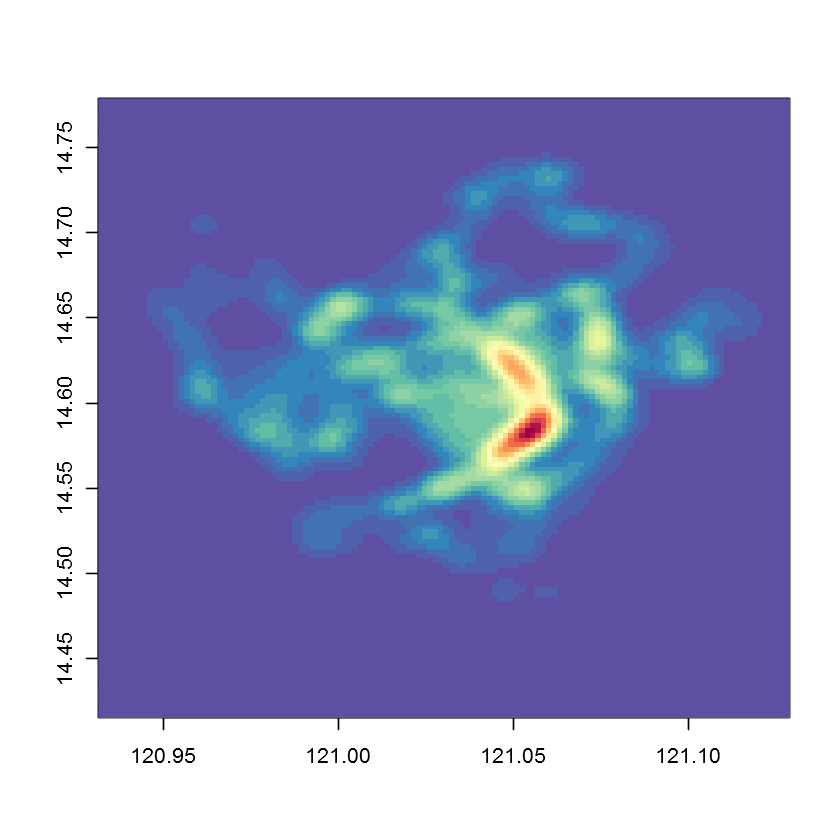

In [10]:
rf <- colorRampPalette(rev(brewer.pal(11,'Spectral')))
r <- rf(32)
image(k, col=r)

## Extract grid values

In [11]:
gr <- data.frame(with(k, expand.grid(x,y)), as.vector(k$z))
names(gr) <- c("lon", "lat", "val")
head(gr)

,lon,lat,val
1,1.209323e+02,1.441678e+01,1.293621e-22
2,1.209338e+02,1.441678e+01,1.548920e-21
3,1.209354e+02,1.441678e+01,1.606190e-20
4,1.209369e+02,1.441678e+01,1.442485e-19
5,1.209385e+02,1.441678e+01,1.121947e-18
6,1.209400e+02,1.441678e+01,7.557553e-18


## Determine the number of clusters

Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 819200)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 819200)"

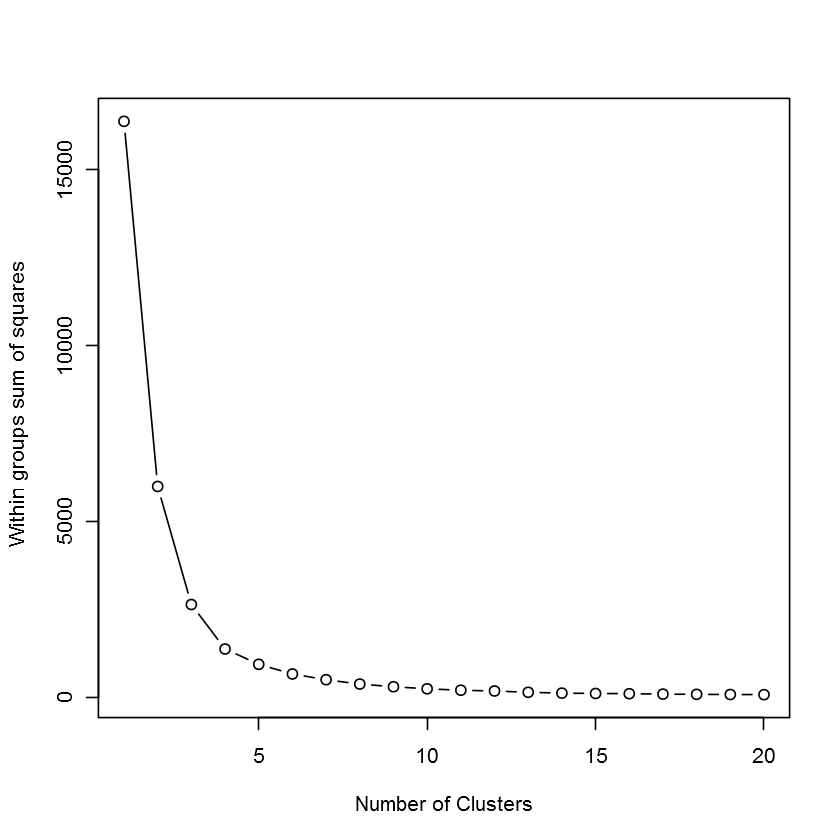

In [12]:
wssplot <- function(data, nc=20, seed=12345){
	wss <- (length(data)-1)*sum(var(data))
	for (i in 2:nc){
		set.seed(seed)
		wss[i] <- sum(kmeans(data, centers=i, iter.max=20)$withinss)}
	plot(1:nc, wss, type="b", xlab="Number of Clusters", ylab="Within groups sum of squares")
}
wssplot(scale(gr$val))

## Cluster values by lon and lat

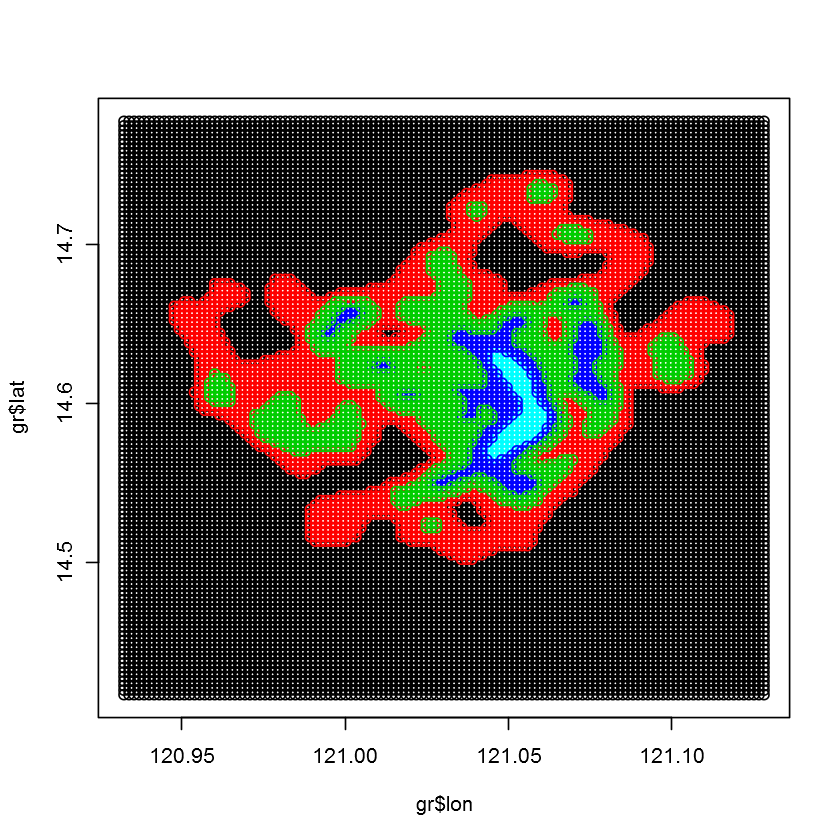

In [13]:
numClusts <- 5
kmeansModel <- kcca(x=scale(gr$val), k=numClusts, family=kccaFamily(which='kmeans'))
gr$cluster <- as.factor(clusters(kmeansModel))
clusterLookUp <- aggregate(val ~ cluster, data=gr, FUN=median)
clusterLookUp <- clusterLookUp[order(clusterLookUp$val),]
clusterLookUp$new_cluster <- c(1:numClusts)
clusterLookUp$val <- NULL
gr <- merge(gr, clusterLookUp, by=intersect(names(gr), names(clusterLookUp)), all.x=TRUE)
gr$cluster <- NULL
names(gr)[names(gr) == 'new_cluster'] <- 'cluster'
gr$cluster <- as.factor(gr$cluster)
plot(x=gr$lon, y=gr$lat, col=gr$cluster)

## Look at the map

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=metro+manila&zoom=13&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=metro%20manila&sensor=false
Warning message:
"Removed 13686 rows containing missing values (geom_tile)."

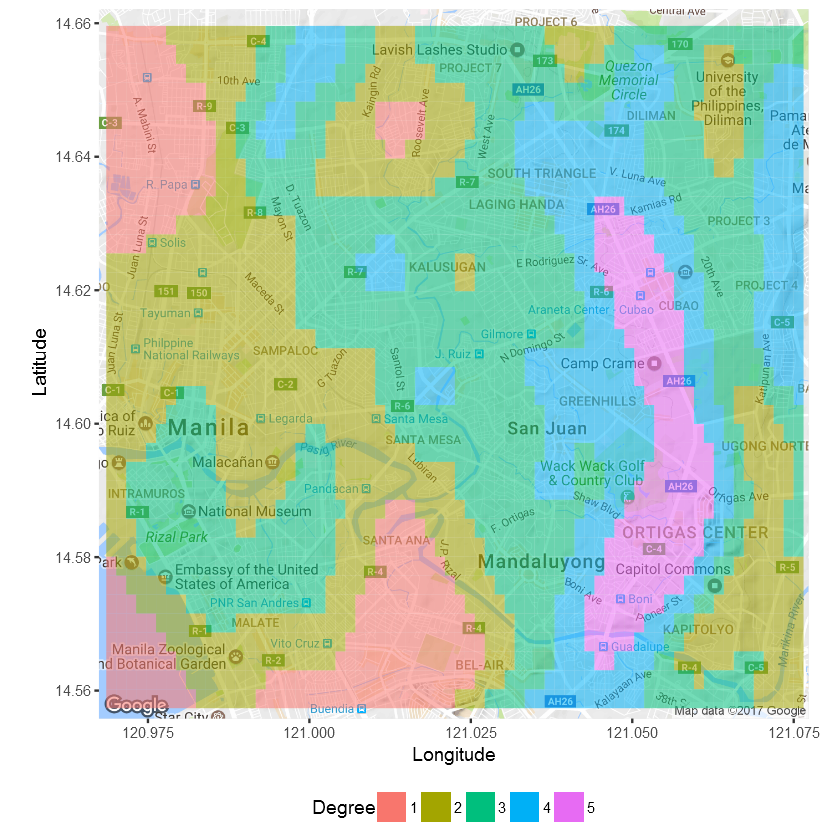

In [16]:
metroManila <- get_map(location = "metro manila", zoom = 13)
ggmap(metroManila) + geom_tile(data = gr, aes(x = lon, y = lat, alpha = 0, fill = cluster)) + 
    labs(x='Longitude', y='Latitude', fill='Degree') + guides(alpha=FALSE) + theme(legend.position = 'bottom')


## Fit a random forest

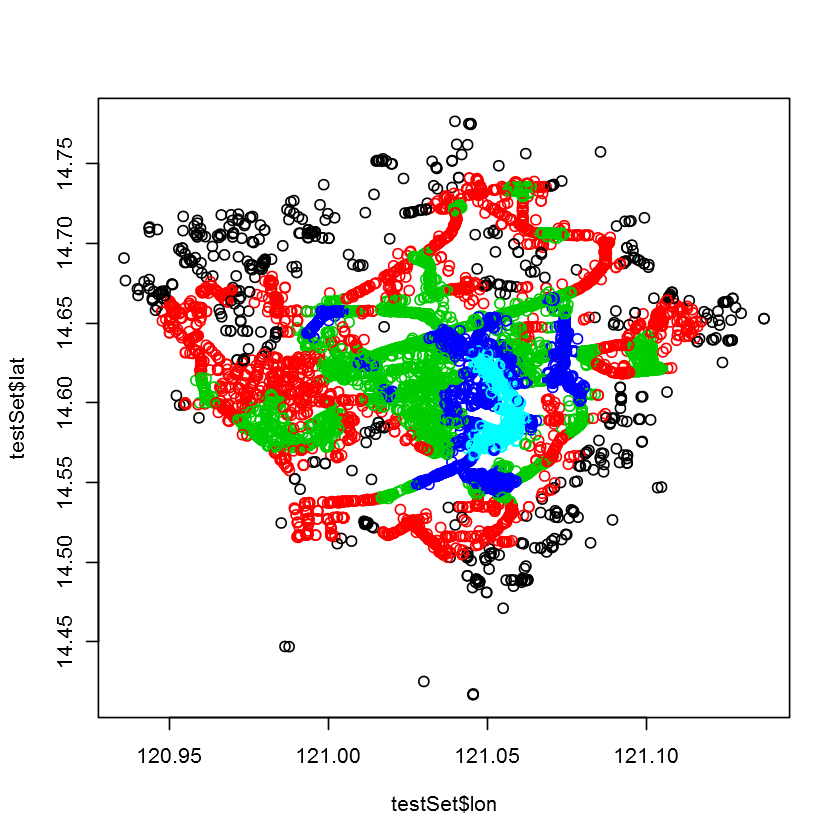

In [17]:
set.seed(11111)
model.RandomForest <- randomForest(x=gr[,c('lon', 'lat')], y=gr$cluster)
testSet$pred_cluster <- predict(model.RandomForest, newdata = data.frame(lon = testSet$lon, lat=testSet$lat), type = 'class')
plot(x=testSet$lon, y=testSet$lat, col=testSet$pred_cluster)

## Look at the map again

Warning message:
"Removed 4047 rows containing missing values (geom_point)."

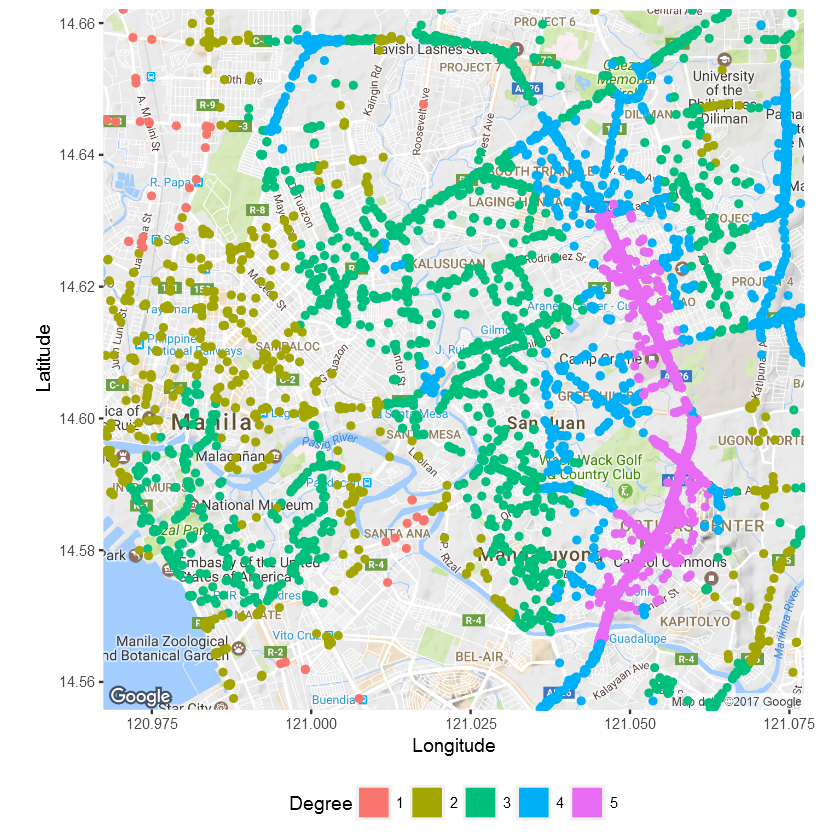

In [18]:
ggmap(metroManila) + geom_point(data = testSet, aes(x = lon, y = lat, col = pred_cluster)) + 
labs(x='Longitude', y='Latitude', color='Degree') + guides(col = guide_legend(override.aes = list(shape = 15, size = 8))) + 
theme(legend.position = 'bottom')

## Thank you
### joebrillantes@gmail.com
### ph.linkedin.com/in/joebrillantes/